In [2]:
import torch
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import evaluate
import accelerate
from datasets import load_dataset, Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, pipeline
from sklearn.metrics import f1_score
import shap
torch.cuda.is_available()

False

In [3]:
# Set the default device globally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

In [4]:
label_map = {'toxic':0, 'severe_toxic':1, 'obscene':2, 'threat':3, 'insult':4, 'identity_hate':5}

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(f"./models/BERT_Multi-Label_classification", num_labels=len(label_map.keys()), hidden_dropout_prob=0.1).to(device)
tokenizer = AutoTokenizer.from_pretrained(f"./models/BERT_Multi-Label_classification")

In [19]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, return_all_scores=True)
explainer = shap.Explainer(classifier,output_names=list(label_map.keys()))


Device set to use cpu


In [20]:
test_dataset = Dataset.from_file(r"processed_dataset/test/data-00000-of-00001.arrow")
def create_multi_label(example):
    return {"labels": [np.float32(example[label]) for label in label_map.keys()]}

test_dataset = test_dataset.map(create_multi_label).remove_columns(list(label_map.keys()))
test_dataset[0]

{'id': '0001ea8717f6de06',
 'comment_text': 'Thank you for understanding. I think very highly of you and would not revert without discussion.',
 'cyberbullying': 0,
 'labels': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [52]:
# Debug the input to ensure it is a list of strings
cyberbullying_texts = [obj['comment_text'] for obj in test_dataset if obj['cyberbullying'] == 1][:10]

In [54]:
# Use the corrected input for SHAP explainer
shap_values = explainer(cyberbullying_texts,batch_size=2)

PartitionExplainer explainer: 11it [02:31, 15.13s/it]                        


In [55]:
shap.plots.text(shap_values[0])

In [58]:
shap_expl = shap_values[0]
label_index = 0
values = shap_expl.values[:, label_index]
base_value = shap_expl.base_values[label_index]
data = shap_expl.data
print(values)
print(base_value)
print(data)

[ 4.54322975e-04  8.28223846e-03  1.38429958e-02  3.99300892e-02
  2.18271625e-02  2.26438966e-03  2.21289525e-03 -9.03598747e-03
 -1.23290761e-02 -1.06102281e-02 -2.89785151e-02 -1.17674492e-02
 -1.62513782e-02 -3.19863595e-03 -5.12335282e-03 -9.90594633e-04
  3.76812135e-03  3.22494608e-03  3.74605459e-03 -4.44237585e-03
 -8.85015424e-03  1.71481619e-01  5.33598634e-02  7.18177102e-01
  8.00291706e-04  0.00000000e+00]
0.0005961072165518999
['' '=' '= ' 'Arabs ' 'are ' 'committing ' 'genocide ' 'in ' 'Iraq' ', '
 'but ' 'no ' 'protests ' 'in ' 'Europe' '. ' '=' '= \n\n ' 'May '
 'Europe ' 'also ' 'burn ' 'in ' 'hell' '.' '']


In [57]:
def plot_text_label(shap_expl, label_index: int, label_name: str = ""):
    values = shap_expl.values[:, label_index]
    base_value = shap_expl.base_values[label_index]
    data = shap_expl.data

    explanation = shap.Explanation(
        values=values,
        base_values=base_value,
        data=data
    )
    print(f"Visualizing SHAP for {label_name} label")
    shap.plots.text(explanation)
plot_text_label(shap_values[0], 0, "toxic")

Visualizing SHAP for toxic label


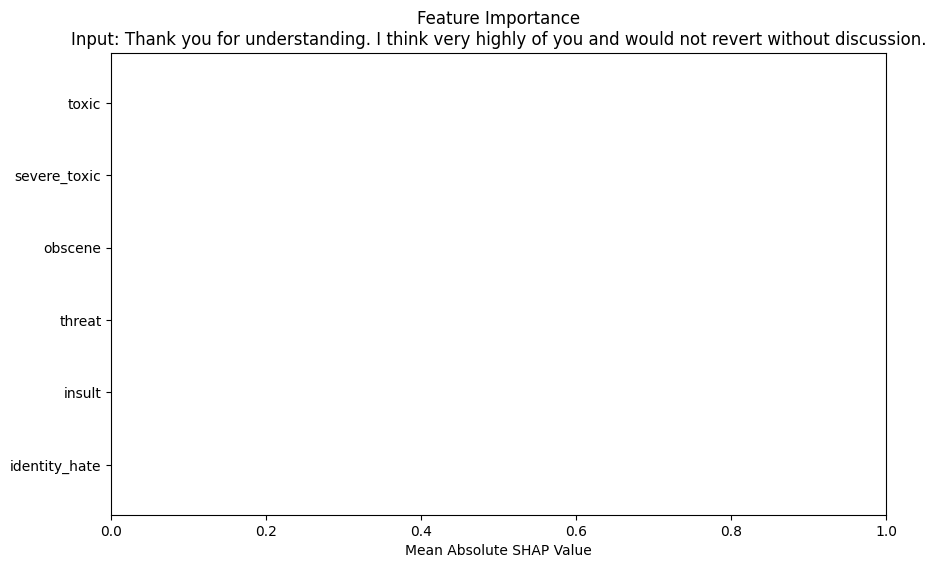

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(shap_values[0].values), axis=0)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(label_map.keys()), mean_abs_shap_values, color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title(f'Feature Importance\nInput: {comment_texts[0]}')
plt.xlim(0,1.0)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Understanding SHAP Values
SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance by attributing the output of a machine learning model to its input features. 
For text classification tasks, SHAP values help explain how individual words or tokens contribute to the model's predictions.

### Key Points:
- Positive SHAP values indicate that a feature (e.g., a word) contributes positively to the prediction of a specific class.
- Negative SHAP values indicate that a feature reduces the likelihood of a specific class.
- SHAP visualizations, such as text plots, bar plots, and beeswarm plots, provide insights into model behavior and feature importance.